In [ ]:
!pip install ipykernel
!pip install medmnist
!pip install matplotlib
!pip install numpy
!pip install scikit-learn
!pip install scikit-image
!pip install scipy
!pip install pandas
!pip install tqdm
!pip install Pillow
!pip install fire
!pip install torch
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=85ec975b0642c234953fabd3a490645edb83f221f1bd77323b6713a71be330ae
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


## Imports

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms

import torch.nn.functional as F
import medmnist
from medmnist import INFO, Evaluator
from torchvision.transforms import Compose, Grayscale, Resize, ToTensor, Normalize

import medmnist
from medmnist import INFO, Evaluator
import os
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from matplotlib import pyplot
import matplotlib.image as mpimg
from torch.utils.data import DataLoader
from tqdm import tqdm

from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, confusion_matrix


## Load OrganAmnist dataset

In [ ]:
data_flag = 'organamnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

print(f"Channels: {n_channels}")
print(f"Classes: {n_classes}")
print(f"Task: {task}")
print(f"labels: {type(info['label']['0'])}")

DataClass = getattr(medmnist, info['python_class'])

Channels: 1
Classes: 11
Task: multi-class
labels: <class 'str'>


In [ ]:
print(f'labels: {info["label"]}')
classes = info["label"].values()
print(classes)

labels: {'0': 'bladder', '1': 'femur-left', '2': 'femur-right', '3': 'heart', '4': 'kidney-left', '5': 'kidney-right', '6': 'liver', '7': 'lung-left', '8': 'lung-right', '9': 'pancreas', '10': 'spleen'}
dict_values(['bladder', 'femur-left', 'femur-right', 'heart', 'kidney-left', 'kidney-right', 'liver', 'lung-left', 'lung-right', 'pancreas', 'spleen'])


In [ ]:
# Config
data_flag = 'organamnist'
download = True

BATCH_SIZE = 64

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# Temporary transformation to load data as tensors without normalization
temp_transform = transforms.Compose([transforms.ToTensor()])
size = 224
# Load the dataset with temporary transformation
train_dataset = DataClass(split='train', transform=temp_transform, download=download, size=size)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False)

mean128 = 0.0
std128 = 0.0
for images, _ in train_loader:
    batch_samples = images.size(0)
    images = images
    mean128 += images.mean([0, 2, 3]) * batch_samples
    std128 += images.std([0, 2, 3], unbiased=False) * batch_samples

mean128 /= len(train_loader.dataset)
std128 /= len(train_loader.dataset)
mean128 = mean128.item()
std128 = std128.item()

data_transform128 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize(mean=[mean128] * 3, std=[std128] * 3)
])

train_dataset128 = DataClass(split='train', transform=data_transform128, download=download, size=size)
val_dataset128 = DataClass(split='val', transform=data_transform128, download=download, size=size)

train_loader128 = DataLoader(dataset=train_dataset128, batch_size=BATCH_SIZE, shuffle=True)
val_loader128 = DataLoader(dataset=val_dataset128, batch_size=2*BATCH_SIZE, shuffle=False)

test_dataset128 = DataClass(split='test', transform=data_transform128, download=download, size=size)
test_loader128 = DataLoader(dataset=test_dataset128, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /root/.medmnist/organamnist_224.npz
Using downloaded and verified file: /root/.medmnist/organamnist_224.npz
Using downloaded and verified file: /root/.medmnist/organamnist_224.npz
Using downloaded and verified file: /root/.medmnist/organamnist_224.npz


In [ ]:
# Visualize the dataset
# plt.figure(figsize=(10,10))
# sample_img_idx = np.random.randint(0, len(train_dataset128), 20)

# for i, j in enumerate(sample_img_idx):
#     image, label = train_dataset128[j]
#     ax=plt.subplot(5,5,i+1)
#     plt.imshow(image[0])
#     plt.title(info['label'][str(label[0])])
#     plt.axis('off')

## Functions

In [ ]:
class CustomViT(nn.Module):
    def __init__(self, num_classes, hidden_layer_sizes=None):
        super(CustomViT, self).__init__()
        self.base_model = models.vit_b_16(weights='DEFAULT')

        for param in self.base_model.parameters():
            param.requires_grad = False

        num_features = self.base_model.heads.head.in_features
        if hidden_layer_sizes:
            layers = []
            input_size = num_features
            for size in hidden_layer_sizes:
                layers.append(nn.Linear(input_size, size))
                layers.append(nn.ReLU())
                input_size = size
            layers.append(nn.Linear(input_size, num_classes))
            self.base_model.heads.head = nn.Sequential(*layers)
        else:
            self.base_model.heads.head = nn.Linear(num_features, num_classes)

        for param in self.base_model.heads.head.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.base_model(x)

In [ ]:
def compute_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    return accuracy

In [ ]:
def save_checkpoint(epoch, model, optimizer, loss):
  torch.save({
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': loss,
  }, f'checkpoint_{epoch}.pth')

In [ ]:
def train(model, optimizer, train_loader, val_loader, batch_size, num_epochs, patience):
    criterion = nn.CrossEntropyLoss()

    history = {"loss": [], "accuracy": [], "val_accuracy": []}
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_weights = model.state_dict()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in tqdm(train_loader):
            labels = labels.squeeze(1)
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                labels = labels.squeeze(1)
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}')
        history["loss"].append(running_loss / len(train_loader))
        history["accuracy"].append(compute_accuracy(model, train_loader, device))
        history["val_accuracy"].append(compute_accuracy(model, val_loader, device))

        save_checkpoint(epoch, model, optimizer, val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model_weights)
    print('Training complete!')
    return history

In [ ]:
def get_model(shape):
    print(f"RUNNING ON {device}")
    custom_vit = CustomViT(num_classes=n_classes, hidden_layer_sizes=[1024, 512, 256])
    custom_vit.to(device)
    return custom_vit

In [ ]:
def setup_and_train(model, train_set, valid_set, batch_size, num_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    return train(model, optimizer, train_set, valid_set, batch_size, num_epochs, patience=3)

## Evaluation functions

In [ ]:
def calc_error(predictions, labels):
    """Return the error rate and confusions."""
    correct = np.sum(predictions == labels)
    print(predictions.shape)
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    confusions = np.zeros([n_classes, n_classes], np.float32)
    bundled = zip(predictions, labels)
    for predicted, actual in bundled:
        confusions[predicted, actual] += 1

    return error, confusions

def get_predictions(model, data_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    probabilities = []

    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            labels = labels.squeeze(1)
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.append(predicted.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            probabilities.append(probs.cpu().numpy())

    return (
        np.concatenate(all_predictions),
        np.concatenate(all_labels),
        np.vstack(probabilities)
    )

In [ ]:
def eval_on_test_set(model, test_loader, batch_size):
    # Get predictions and labels
    test_predictions, test_labels, probs = get_predictions(model, test_loader, device)
    test_labels = np.array(test_labels)
    test_predictions = np.array(test_predictions)
    test_probs = np.array(probs)

    # Confusion matrix
    test_conf_mat = confusion_matrix(test_labels, test_predictions)

    # Accuracy
    accuracy = accuracy_score(test_labels, test_predictions)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Recall (macro and per class)
    recall_macro = recall_score(test_labels, test_predictions, average='macro')
    recall_per_class = recall_score(test_labels, test_predictions, average=None)
    print(f"Recall (Macro): {recall_macro * 100:.2f}%")

    # Precision (macro and per class)
    precision_macro = precision_score(test_labels, test_predictions, average='macro')
    precision_per_class = precision_score(test_labels, test_predictions, average=None)
    print(f"Precision (Macro): {precision_macro * 100:.2f}%")

    auc = roc_auc_score(test_labels, test_probs, multi_class='ovr')
    print(f"AUC: {auc:.2f}")

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(False)
    plt.xticks(np.arange(len(test_conf_mat)), labels=np.arange(len(test_conf_mat)))
    plt.yticks(np.arange(len(test_conf_mat)), labels=np.arange(len(test_conf_mat)))
    plt.imshow(test_conf_mat, cmap=plt.cm.jet, interpolation='nearest')

    for i, cas in enumerate(test_conf_mat):
        for j, count in enumerate(cas):
            if count > 0:
                xoff = .07 * len(str(count))
                plt.text(j - xoff, i + .2, int(count), fontsize=9, color='white')

    plt.show()

In [ ]:
def plot_hist(history):
    plt.figure(figsize=(8,8))

    plt.subplot(211)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    # History for loss
    plt.subplot(212)
    plt.plot(history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

## Run the training and evaluation

In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
num_epochs = 15
batch_size = 256

In [ ]:
x, y = train_dataset[0]
model = get_model(x.shape)
print(x.shape)

RUNNING ON cuda


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 216MB/s]


torch.Size([1, 224, 224])


In [ ]:
history = setup_and_train(model, train_loader128, val_loader128, batch_size, num_epochs)

100%|██████████| 541/541 [01:52<00:00,  4.80it/s]


Epoch [1/15], Loss: 0.4238, Val Loss: 0.0946


100%|██████████| 541/541 [01:51<00:00,  4.85it/s]


Epoch [2/15], Loss: 0.1191, Val Loss: 0.0533


100%|██████████| 541/541 [01:51<00:00,  4.86it/s]


Epoch [3/15], Loss: 0.0843, Val Loss: 0.0593


100%|██████████| 541/541 [01:51<00:00,  4.87it/s]


Epoch [4/15], Loss: 0.0647, Val Loss: 0.0704


100%|██████████| 541/541 [01:51<00:00,  4.84it/s]


Epoch [5/15], Loss: 0.0455, Val Loss: 0.0495


100%|██████████| 541/541 [01:51<00:00,  4.87it/s]


Epoch [6/15], Loss: 0.0343, Val Loss: 0.0538


100%|██████████| 541/541 [01:52<00:00,  4.82it/s]


Epoch [7/15], Loss: 0.0275, Val Loss: 0.0738


100%|██████████| 541/541 [01:51<00:00,  4.85it/s]


Epoch [8/15], Loss: 0.0202, Val Loss: 0.0601
Early stopping triggered.
Training complete!


In [ ]:
loss_train = [0.4238, 0.1191, 0.0843, 0.0647, 0.0455, 0.0343, 0.0275, 0.0202]
loss_valid = [0.0946, 0.0533, 0.0593, 0.0704, 0.0495, 0.0538, 0.0738, 0.0601]

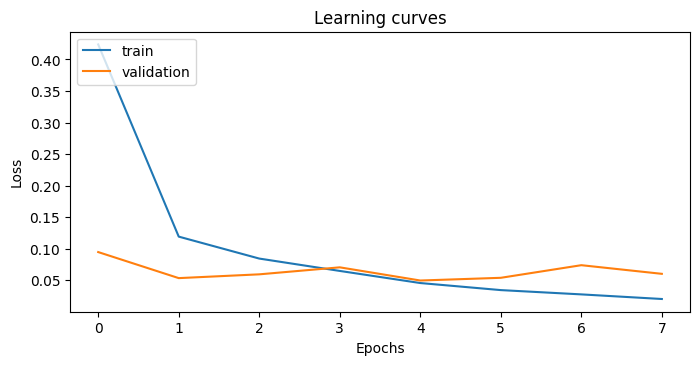

In [ ]:
plt.figure(figsize=(8,8))

plt.subplot(211)
plt.plot(loss_train)
plt.plot(loss_valid)
plt.title('Learning curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

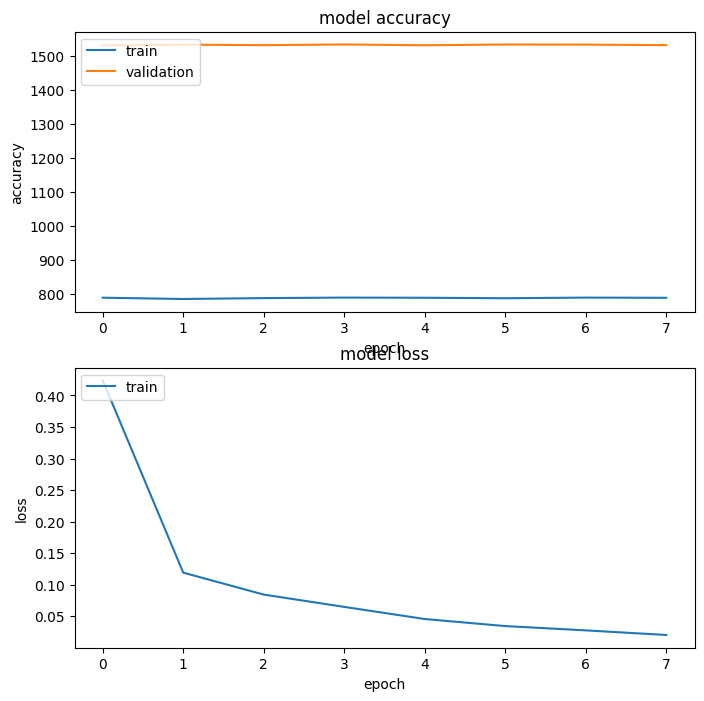

In [ ]:
plot_hist(history)

100%|██████████| 51/51 [00:17<00:00,  2.89it/s]


Accuracy: 98.14%
Recall (Macro): 98.05%
Precision (Macro): 98.26%
AUC: 1.00


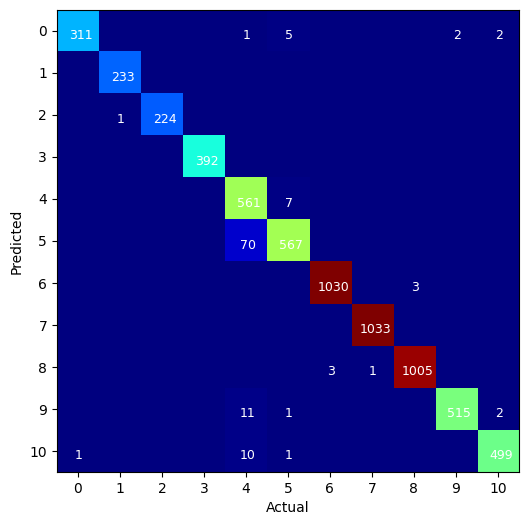

In [ ]:
eval_on_test_set(model, val_loader128, batch_size)

100%|██████████| 139/139 [00:48<00:00,  2.88it/s]


Accuracy: 94.57%
Recall (Macro): 94.01%
Precision (Macro): 94.56%
AUC: 1.00


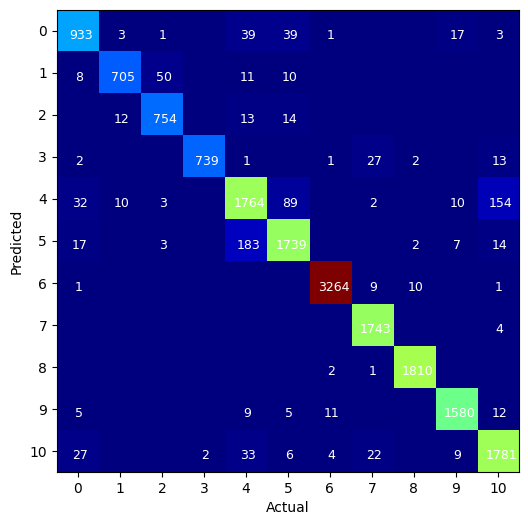

In [ ]:
eval_on_test_set(model, test_loader128, batch_size)

In [ ]:
torch.save(model.state_dict(), 'fine_tuned_vit_state_dict.pth')